In [1]:
import sys
import visualization 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from IPython.display import display, Math, Latex, HTML
from mpl_toolkits.mplot3d.axes3d import Axes3D
from ipywidgets import interact, IntSlider, interactive
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Title
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import gridplot, row


import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(0)
tf.set_random_seed(0)
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

## Data

In [2]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
print ('number of sumples:', n_samples)

number of sumples: 55000


## some model utils

In [4]:
# feed_forward model structure
from keras.layers import Input, Dense
from keras.models import Sequential, Model

def feed_forward(input_dim, layers):
    """
    Return a keras model object.
    input_dim: the orginial input dims
    layers: a list specifying the dims of each layer
    """
    model = Sequential()
    for i in range(len(layers)):
        if i == 0:
            model.add(Dense(layers[i], input_shape=(input_dim,), activation='relu'))
        else:
            model.add(Dense(layers[i], activation='relu'))
    return model

Using TensorFlow backend.


## VAE

In [5]:
class VA(object):
    def __init__(self, batch_size, input_dim, latent_dim, lr):
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self._initialize()

    def _initialize(self):
        # placeholder for input data
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        # create network
        self.create_network()
        self.loss()
        # init tensorflow graph
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def encoder_network(self, x):
        """
        Takes in x, and return parameters of latents z.
        """
        # two intermediate layer
        layers = [32, 32]
        h = feed_forward(self.input_dim, layers)(x)
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        """
        Takes in the parameters for z, and return samples.
        """
        epsilon = tf.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                   stddev=1.0)
        z = z_mean + tf.exp(z_log_var / 2) * epsilon
        return z

    def decoder_network(self, z):
        """
        Take latents, and return reconstruction.
        """
        layers = [32, 32]
        h = feed_forward(self.latent_dim, layers)(z)
        x_recon_mean = Dense(self.input_dim, activation='sigmoid')(h)
        return x_recon_mean

    def create_network(self):
        self.z_mean, self.z_log_var = self.encoder_network(self.x)
        self.z = self.sampling(self.z_mean, self.z_log_var)
        self.x_decoded = self.decoder_network(self.z)

    def loss(self):
        kl_loss = -0.5 * tf.reduce_sum(1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var), axis=1)
        xent_loss = -tf.reduce_sum(
            self.x * tf.log(1e-9 + self.x_decoded) + (1 - self.x) * tf.log(1e-9 + 1 - self.x_decoded), 1)
        self.cost = tf.reduce_mean(kl_loss + xent_loss)
        self.opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.cost)

    def minbatch_fit(self, X):
        opt, cost = self.sess.run((self.opt, self.cost), feed_dict={self.x: X})
        return cost

    def latent_space_visulization(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def recons(self, X):
        return self.sess.run(self.x_decoded, feed_dict={self.x: X})

    def generating_samples(self, z_mu):
        return self.sess.run(self.x_decoded, feed_dict={self.z: z_mu})


In [6]:
batch_size=100
input_dim = 784
latent_dim = 2
lr = 0.001

va = VA(batch_size, input_dim, latent_dim, lr)

## Training

In [7]:
training_epochs=30
printing = 1

In [8]:
x_sample_m, y_labels_m = mnist.test.next_batch(3000)
cost_plotting=[]
laten_space=[]
reconstructed=[]
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        cost = va.minbatch_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % printing == 0:
        cost_plotting.append(avg_cost)
        laten_space.append(va.latent_space_visulization(x_sample_m))
        reconstructed.append(va.recons(x_sample_m[:100]))
        print("Ittiration:", '%02d' % (epoch+1), "Average_cost=", "{:.9f}".format(avg_cost))

Ittiration: 01 Average_cost= 221.066947965
Ittiration: 02 Average_cost= 183.450487255
Ittiration: 03 Average_cost= 174.573033309
Ittiration: 04 Average_cost= 169.246527516
Ittiration: 05 Average_cost= 166.593282720
Ittiration: 06 Average_cost= 164.704784157
Ittiration: 07 Average_cost= 162.826196234
Ittiration: 08 Average_cost= 161.416797319
Ittiration: 09 Average_cost= 160.303624989
Ittiration: 10 Average_cost= 159.507274974
Ittiration: 11 Average_cost= 158.788719427
Ittiration: 12 Average_cost= 158.146504239
Ittiration: 13 Average_cost= 157.529289301
Ittiration: 14 Average_cost= 156.974297347
Ittiration: 15 Average_cost= 156.512923584
Ittiration: 16 Average_cost= 156.060532254
Ittiration: 17 Average_cost= 155.651247586
Ittiration: 18 Average_cost= 155.298984680
Ittiration: 19 Average_cost= 154.917903748
Ittiration: 20 Average_cost= 154.642072726
Ittiration: 21 Average_cost= 154.336820096
Ittiration: 22 Average_cost= 154.034073653
Ittiration: 23 Average_cost= 153.809162625
Ittiration:

## Let's look at the results.

In [11]:
visu=visualization.Visualization(total_epoch=training_epochs, batch_size=batch_size, printing=printing)

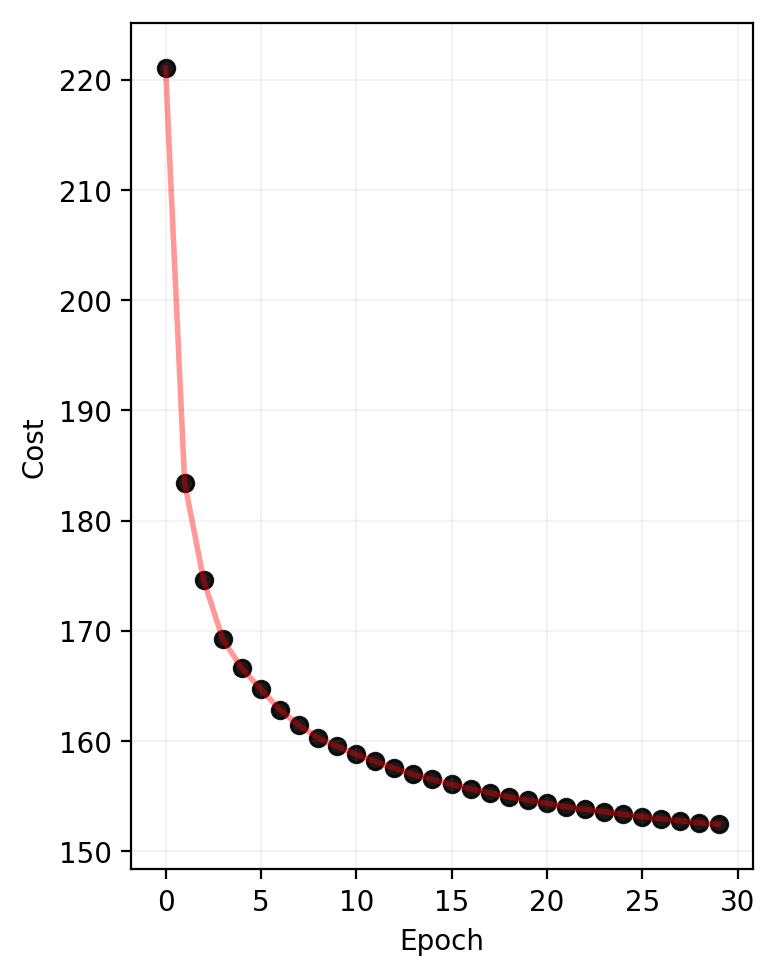

In [12]:
#train cost
visu.plotting_cost(cost_plotting)

In [16]:
#latens space visualization our training
visu.plotting_latent_space(laten_space, y_labels_m)

In [17]:
# reconstruction visualization
visu.plotting_training_visual(reconstructed, x_sample_m[:100])

Loading BokehJS ...

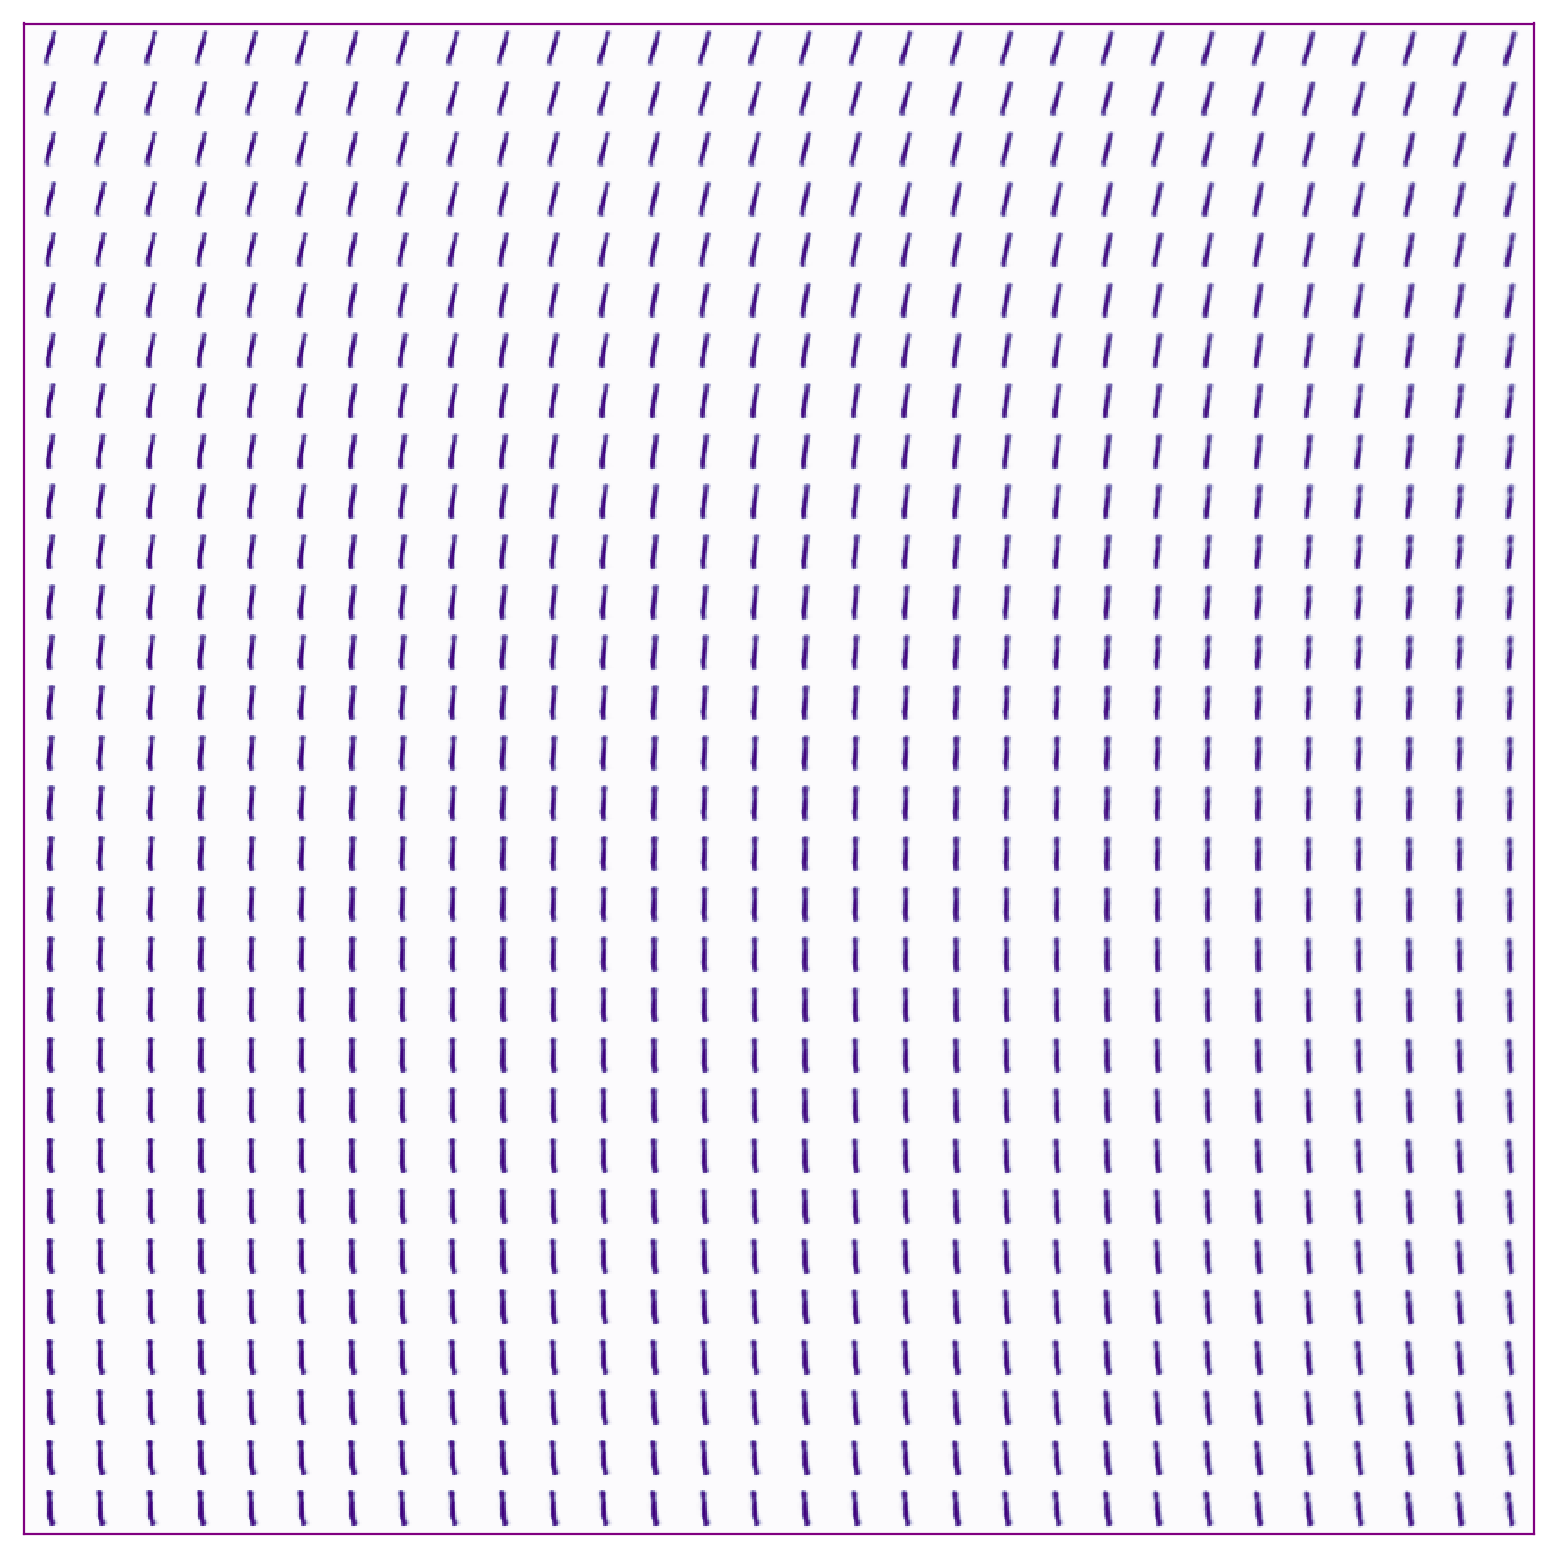

In [15]:
#generation of new data using custum mean
visu.plott_gener_sample_from_dist(va, -2, 0, -2, -3)